In [6]:
import sqlite3
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt


In [7]:
conn = sqlite3.connect("../../places.sqlite")

full_data = pd.read_sql_query(
    """
SELECT 
	moz_places.url as url,
    moz_historyvisits.'visit_date' as 'visit_date'
from moz_historyvisits
    join moz_places on moz_places.id = moz_historyvisits.place_id;
    
""",
    conn,
)

# region 1

# full_data = pd.read_sql_query(
#     """
# SELECT
# 	moz_places.url as pl_url,
#     moz_places.visit_count as pl_visit_count,
#     moz_places.frecency as pl_url_frecency,
#     moz_places.last_visit_date as pl_last_visit_date,
#     moz_historyvisits.'from_visit' as 'his_from_visit',
#     moz_historyvisits.'visit_date' as 'his_visit_date',
#     moz_historyvisits.'visit_type' as 'his_visit_type'
# from moz_historyvisits
#     join moz_places on moz_places.id = moz_historyvisits.place_id;

# """,
#     conn,
# )

# endregion

# full_data[full_data["visit_count"] == 0] = 1


In [8]:
full_data.head()


,url,visit_date
0,https://spins.fedoraproject.org/,1652190849558000
1,https://spins.fedoraproject.org/,1654098416035000
2,https://spins.fedoraproject.org/,1656856015277000
3,https://spins.fedoraproject.org/,1666263920924000
4,https://spins.fedoraproject.org/,1668600233996000


In [9]:
import csv
import re

full_data["host"] = full_data["url"].map(
    lambda x: re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x).group(1)
    if re.match(r"https?:\/\/(([^/]+\.)+[^/]+)", x) is not None
    else pd.NA
)


full_data.to_csv("full_data.csv", index=False, quoting=csv.QUOTE_ALL)
full_data["host"].isna().sum()


2229

In [10]:
from datetime import datetime

full_data["visit_date_obj"] = full_data["visit_date"].map(
    lambda x: datetime.fromtimestamp(x / 1000000)
)


In [11]:
full_data.drop("url", axis=1, inplace=True)
full_data["visit_count"] = 1

full_data.dropna(axis=0, how="any", inplace=True)
full_data.reset_index(inplace=True, drop=True)

full_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66210 entries, 0 to 66209
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   visit_date      66210 non-null  int64         
 1   host            66210 non-null  object        
 2   visit_date_obj  66210 non-null  datetime64[ns]
 3   visit_count     66210 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 2.0+ MB


In [12]:
full_data.head()


,visit_date,host,visit_date_obj,visit_count
0,1652190849558000,spins.fedoraproject.org,2022-05-10 13:54:09.558,1
1,1654098416035000,spins.fedoraproject.org,2022-06-01 15:46:56.035,1
2,1656856015277000,spins.fedoraproject.org,2022-07-03 13:46:55.277,1
3,1666263920924000,spins.fedoraproject.org,2022-10-20 11:05:20.924,1
4,1668600233996000,spins.fedoraproject.org,2022-11-16 12:03:53.996,1


In [13]:
time_frames = {
    "morning": (5, 11),
    "afternoon": (11, 17),
    "evening": (17, 23),
    # "night": (23, 5),
}

modified_data = pd.DataFrame()

modified_data["host"] = full_data["host"].unique()

for time_frame, (start, end) in time_frames.items():
    modified_data = modified_data.merge(
        full_data[
            (
                (full_data["visit_date_obj"].dt.hour >= start)
                & (full_data["visit_date_obj"].dt.hour < end)
            )
        ]
        .groupby("host")
        .agg({"visit_count": "sum"})
        .rename(columns={"visit_count": f"visits_{time_frame}"})
        .astype({f"visits_{time_frame}": pd.Int64Dtype()})
        .reset_index(),
        on="host",
        how="left",
    )

modified_data = modified_data.merge(
    full_data[
        (
            (full_data["visit_date_obj"].dt.hour < 5)
            | (full_data["visit_date_obj"].dt.hour <= 23)
        )
    ]
    .groupby("host")
    .agg({"visit_count": "sum"})
    .rename(columns={"visit_count": f"visits_night"})
    .astype({f"visits_night": pd.Int64Dtype()})
    .reset_index(),
    on="host",
    how="left",
)

modified_data["total_visits"] = modified_data[
    ["visits_morning", "visits_afternoon", "visits_evening", "visits_night"]
].sum(axis=1)

modified_data = modified_data.fillna(0)

modified_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2180 entries, 0 to 2179
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   host              2180 non-null   object
 1   visits_morning    2180 non-null   Int64 
 2   visits_afternoon  2180 non-null   Int64 
 3   visits_evening    2180 non-null   Int64 
 4   visits_night      2180 non-null   Int64 
 5   total_visits      2180 non-null   int64 
dtypes: Int64(4), int64(1), object(1)
memory usage: 110.8+ KB


In [14]:
modified_data.head()


,host,visits_morning,visits_afternoon,visits_evening,visits_night,total_visits
0,spins.fedoraproject.org,4,10,0,14,28
1,www.redhat.com,37,75,2,117,231
2,www.wikipedia.org,2,2,1,5,10
3,www.mozilla.org,3,1,0,4,8
4,addons.mozilla.org,57,50,25,133,265


In [15]:
top_30_data = modified_data.sort_values(by="total_visits", ascending=False).iloc[1:41]

# 'host',	'host_frecency',	'total_visits',	'visits_morning',	'visits_afternoon',	'visits_evening',	'visits_night'

# Melt the dataset to combine "visits_morning," "visits_afternoon," etc. into a "time" column
top_30_data = top_30_data.melt(
    id_vars=["host", "total_visits"],
    value_vars=["visits_morning", "visits_afternoon", "visits_evening", "visits_night"],
    var_name="visit_TOD",
    value_name="visit_count_TOD",
)

top_30_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   host             160 non-null    object
 1   total_visits     160 non-null    int64 
 2   visit_TOD        160 non-null    object
 3   visit_count_TOD  160 non-null    Int64 
dtypes: Int64(1), int64(1), object(2)
memory usage: 5.3+ KB


/home/ubuntu/FDS/.venv/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


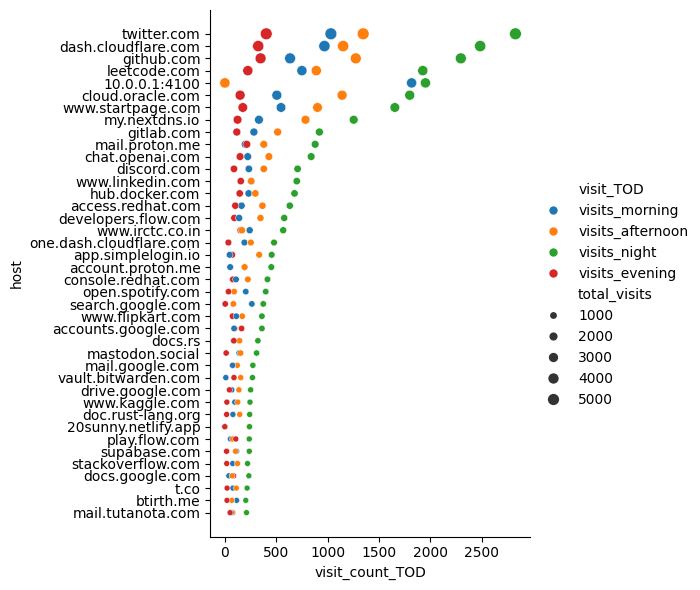

In [16]:
ax = sns.relplot(
    x="visit_count_TOD",
    y="host",
    data=top_30_data.sort_values(by="total_visits", ascending=False),
    hue="visit_TOD",
    size="total_visits",
    height=6,
    aspect=1,
    legend="brief",
)

# ax.set_xticklabels(rotation=90, ha="right", fontsize=9, y=1)

plt.show()


<Axes: >

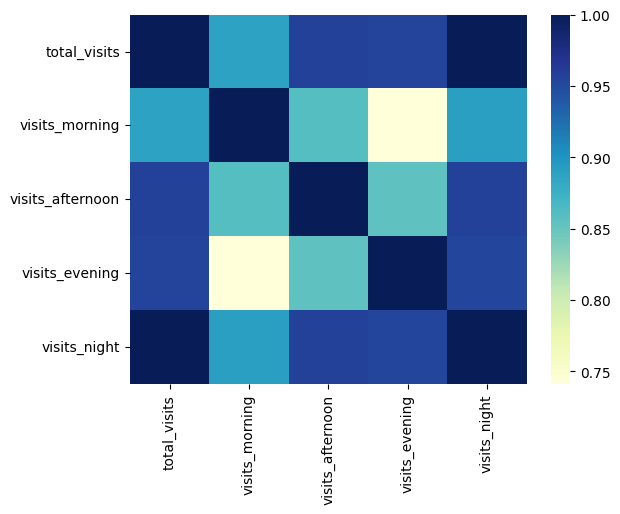

In [17]:
sns.heatmap(
    data=modified_data[
        [
            "total_visits",
            "visits_morning",
            "visits_afternoon",
            "visits_evening",
            "visits_night",
        ]
    ].corr(),
    cmap="YlGnBu",
    # square=True,
)


In [18]:
# x has all cols except host
X = modified_data.drop("host", axis=1)
Y = modified_data["host"]

features_list = [
    "total_visits",
    "visits_morning",
    "visits_afternoon",
    "visits_evening",
    "visits_night",
]


In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)


In [20]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import r2_score


In [21]:
ohe = OneHotEncoder()
ohe.fit(
    X,
)


OneHotEncoder()

In [22]:
column_trans = make_column_transformer(
    (
        OneHotEncoder(categories=ohe.categories_),
        features_list,
    ),
    remainder="passthrough",
)


In [23]:
lr = LinearRegression()
pipe = make_pipeline(column_trans, lr)
pipe.fit(X_train, Y_train)


ValueError: Found unknown categories [46, 50, 58, 60, 66, 74, 80, 82, 84, 86, 87, 88, 96, 98, 102, 104, 106, 108, 110, 114, 116, 117, 118, 119, 121, 122, 125, 126, 130, 132, 133, 136, 137, 140, 142, 146, 148, 150, 152, 154, 156, 158, 162, 166, 174, 178, 180, 181, 182, 185, 188, 192, 196, 200, 210, 216, 224, 231, 248, 255, 257, 264, 267, 271, 282, 284, 326, 327, 334, 336, 346, 351, 358, 370, 376, 398, 403, 408, 429, 430, 441, 474, 476, 480, 484, 488, 501, 523, 638, 712, 724, 729, 826, 888, 958, 1156, 1263, 1368, 1410, 1640, 1670, 3278, 3770, 3790, 4553, 5608] in column 0 during fit